In [1]:
import keras
from keras import Sequential
from keras.layers  import Dense, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Helper libraries
import numpy as np  # Keras needs an older version of numpy
import matplotlib.pyplot as plt
from collections import OrderedDict
import seaborn as sns

import json
import pandas as pd
import time

Using TensorFlow backend.


In [2]:
from RProp import RProp
from WameAdapted import WameAdapted

## Import Landsat

In [3]:
def extract_data_lables(file):
    data, lables = [], []
    with open(file, "r") as f:
        for row in f:
            row = row.split()
            row = [int(i) for i in row]
            lables.append(row.pop(-1))
            data.append(row)
        return np.array(data), np.array(lables)

In [4]:
train_data, train_lables = extract_data_lables("data\landsat\sat.trn")

In [5]:
test_data, test_lables  = extract_data_lables("data\landsat\sat.tst")

In [6]:
print(len(train_data))
print(len(test_data))

4435
2000


### Clean Lables

In [7]:
# decriment to index from zero
train_lables -= 1
test_lables -= 1

In [8]:
class_names = {
    0:'red soil'
    ,1:'cotton crop'
    ,2:'grey soil'
    ,3:'damp grey soil'
    ,4:'soil with vegetation stubble'
    ,5:'mixture class (all types present)'
    ,6:'very damp grey soil'
}

In [9]:
np.bincount(train_lables)

array([1072,  479,  961,  415,  470,    0, 1038], dtype=int64)

## Preprocess Images

In [10]:
# scale pixels to 0-1
train_data = train_data / 255.0
test_data = test_data / 255.0

TODO: Find a way to optimise these layers (will be needed for report)

## One-hot encode lables
Class lables need to be in an n x c array format

In [11]:
from sklearn.preprocessing import OneHotEncoder

In [12]:
ohe = OneHotEncoder(sparse=False)
train_y = ohe.fit_transform(train_lables.reshape(-1, 1))
test_y = ohe.transform(test_lables.reshape(-1, 1))

In [13]:
train_data.shape

(4435, 36)

In [14]:
train_y.shape

(4435, 6)

In [15]:
train_y.sum()

4435.0

## Functions for creating and testing models

In [16]:
def create_seq_model(n_hidden=1, n_neurons=36):
    """Create a sequential network with (1) hidden layers and (2) neurons in each layer.
    Hidden layers are dense with relu activation"""
    model = Sequential()
    # First hidden layer
    model.add(Dense(n_neurons, input_dim=36))  # input_dim easier to use than input_shape
    model.add(Activation('relu'))
    # Additional hidden layers
    for i in range(n_hidden-1):
        model.add(Dense(n_neurons))
        model.add(Activation('relu'))
    # output layer
    model.add(Dense(6))  
    model.add(Activation('sigmoid'))
    return model

In [17]:
def train_test_model(model, optimiser):
    """Trains a model using 25% validation split each epoch, then tests the model with the best validation performance.
    batch_size = 100, maximum epochs =100"""
    
    model.compile(optimizer=optimiser
              ,loss='categorical_crossentropy'
              ,metrics=['accuracy']
             )
    
    start_t = time.time()
    
    history =  model.fit(
        train_data
        , train_y
        , epochs=100
        , validation_split=0.25
        , verbose=0
        , batch_size=32
        , shuffle = True
        ,callbacks = [
            EarlyStopping(verbose=False, min_delta=0.0001, patience=15, monitor='val_acc', mode='max', restore_best_weights=True),
        #    ModelCheckpoint('TestModel-progress'+str(counter), monitor='val_acc', verbose=False, save_best_only=True)
        ]
    )
    
    time_s = time.time() - start_t
    
    train_loss, train_acc = model.evaluate(train_data,  train_y, verbose = 0)
    test_loss, test_acc = model.evaluate(test_data,  test_y, verbose = 0)
    
    epochs = history.history['val_acc']
    best_epoch = epochs.index(max(epochs))
    total_epochs = len(epochs)
    sec_per_epoch = time_s / total_epochs
    
    return (train_acc, test_acc, train_loss, test_loss, best_epoch, sec_per_epoch, history)   

In [18]:
def train_test_grid(n_hidden_lst, n_neurons_lst, optimiser, json_out, n_experiments=20):
    """Create, train and test multiple models using various structures. 
    Each structure is trialled via multiple experiments. Experiments uses a repeated sequence of random seeds.
    Outputs: 
        - a (json-style) list of dictionaries of metrics from the experiments."""
    
    results = []
    
    if isinstance(optimiser, str):
        opt_alias = optimiser
    else:
        opt_alias = type(optimiser).__name__
        
    print( len(n_hidden_lst)*len(n_neurons_lst), 'sets of', n_experiments, 'experiments to perform.')
    
    counter = 0
    for i, n_hidden in enumerate(n_hidden_lst):
        for j, n_neurons in enumerate(n_neurons_lst):
            record_dict = OrderedDict({
                'hidden_layers': n_hidden
                ,'neurons': n_neurons
                ,'optimiser': opt_alias
                ,'n_experiments': n_experiments
                ,'train_accuracies': []
                ,'test_accuracies': []
                ,'train_losses' : []
                ,'test_losses' : []
                ,'best_epochs': []
                ,'seconds_per_epoch': []
            })
            
            for k in range(n_experiments):
                np.random.seed(10+k)
                model = create_seq_model(n_hidden, n_neurons)
                train_acc, test_acc, train_loss, test_loss, best_epoch, sec_per_epoch, _ = train_test_model(model, optimiser)
                record_dict['train_accuracies'].append(train_acc)
                record_dict['test_accuracies'].append(test_acc)
                record_dict['train_losses'].append(train_loss)
                record_dict['test_losses'].append(test_loss)
                record_dict['best_epochs'].append(best_epoch)
                record_dict['seconds_per_epoch'].append(sec_per_epoch)
            
            record_dict['avg_train_acc'] = sum(record_dict['train_accuracies'])/len(record_dict['train_accuracies'])
            record_dict['avg_test_acc'] = sum(record_dict['test_accuracies'])/len(record_dict['test_accuracies'])
            record_dict['avg_epoch'] = sum(record_dict['best_epochs'])/len(record_dict['best_epochs'])
            record_dict['avg_sec_per_epoch'] = sum(record_dict['seconds_per_epoch'])/len(record_dict['seconds_per_epoch'])
            record_dict['min_test_acc'] = min(record_dict['test_accuracies'])
            record_dict['max_test_acc'] = max(record_dict['test_accuracies'])
            record_dict['stdev_test_acc'] = np.std(record_dict['test_accuracies'])
            record_dict['serr_test_acc'] = record_dict['stdev_test_acc'] / (record_dict['n_experiments']**0.5)
            record_dict['CI_95'] = record_dict['serr_test_acc'] * 1.96
            
            results.append(record_dict)
            counter += 1
            with open(json_out, 'w') as f:
                json.dump(results, f)
            print(counter, 'sets done')
    print('done!')
    return results

##### Test various 'adam' configurations

In [19]:
n_hidden_lst = [1, 2, 3]
n_neurons_lst = [10, 20, 30, 40]

In [20]:
# Run once:
# Commented out after running 
# adam_results = train_test_grid(n_hidden_lst, n_neurons_lst, 'adam', 'results/adam_results.json', n_experiments=20)

#### Test various WAME configurations using WAME that is almost the same as the paper except with sqrt theta

In [22]:
# Run once:
# Commented out after running 
# wameAdapted_results = train_test_grid(n_hidden_lst, n_neurons_lst, WameAdapted(), 'results/wameAdapted_results_2.json', n_experiments=20)

Instructions for updating:
Colocations handled automatically by placer.
12 sets of 20 experiments to perform.
Instructions for updating:
Use tf.cast instead.
1 sets done
2 sets done
3 sets done
4 sets done
5 sets done
6 sets done
7 sets done
8 sets done
9 sets done
10 sets done
11 sets done
12 sets done
done!


In [22]:

# model = Sequential()
# model.add(Dense(40, input_dim=36))  # input_dim easier to use than input_shape
# model.add(Activation('relu'))

# model.add(Dense(40))
# model.add(Activation('relu'))

# model.add(Dense(6))  
# model.add(Activation('sigmoid'))
    
# model.compile(optimizer=WameAdapted()
#               ,loss='categorical_crossentropy'
#               ,metrics=['accuracy']
#              )
    
# np.random.seed(123)

# history =  model.fit(
#     train_data
#     , train_y
#     , epochs=100
#     , validation_split=0.25
#     , verbose=0
#     , batch_size=32
#     , shuffle = True
#     ,callbacks = [
#         EarlyStopping(verbose=False, min_delta=0.0001, patience=15, monitor='val_acc', mode='max', restore_best_weights=True),
#     #    ModelCheckpoint('TestModel-progress'+str(counter), monitor='val_acc', verbose=False, save_best_only=True)
#     ]
# )
    

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [23]:
# history.history['val_acc']

[0.08566275924256087,
 0.5256988279608803,
 0.7439134355409388,
 0.7808836794200515,
 0.7844905323870447,
 0.711451758770818,
 0.6934174937746136,
 0.7366997298622475,
 0.7511271419989515,
 0.6077547340214629,
 0.5996393147247993,
 0.6537421100358903,
 0.7583408480404302,
 0.7799819661111204,
 0.6907123540090591,
 0.773669973432319,
 0.7312894503848847,
 0.7141568985901189,
 0.6555455369493572,
 0.7709648336130182]

#### Helper functions for reporting results

In [24]:
def best_test(results):
    """Helper function to retrieve the dictionary with the best average test accuracy from a results list"""
    best_result = results[0]
    best_test = results[0]['avg_test_acc']
    for r in results:
        if r['avg_test_acc'] > best_test:
            best_test = r['avg_test_acc']
            best_result = r
    return r

In [25]:
def retrieve_experiment(results, conditions):
    """results - dictionary output of train_test_grid()
    conditions - a dictionary of keys and values that we want to match
    will return the first experiment to match"""
    for r in results:
        matched = True
        for k, v in conditions.items():
            if r[k] != v:
                matched = False
                break
        if matched:
            return r

def print_kpis(r):
    print('test_acc', round(r['avg_test_acc']*100,1))
    print('+- \t', round(r['CI_95']*100,1))
    print('stdev\t', round(r['stdev_test_acc']*100,1))
    print('epoch\t', round(r['avg_epoch'],1))
    print('time\t', round(r['avg_sec_per_epoch'],2))
    

In [42]:
conditions = {'hidden_layers': 3
              ,'neurons': 40}

print_kpis(retrieve_experiment(wameAdapted_results, conditions))

test_acc 77.9
+- 	 2.6
stdev	 5.9
epoch	 13.1
time	 2.13


### Box and Whisker Plots

In [44]:
def df_from_results(results):
    """Helper function to create a tidy DataFrame from a results set. 
    Tidy dataframe is an easier format for data viz. and tabulation
    The format of the DF is that there is a row per experiment (e.g. 20 experiments per arrangement)"""
    
    contents = []
    for r in results:
        col1 = r['optimiser']
        col2 = r['hidden_layers']
        col3 = r['neurons']
        for e in range(r['n_experiments']):
            col4 = r['train_accuracies'][e]
            col5 = r['test_accuracies'][e]
            contents.append([col1, col2, col3, col4, col5])
    
    df = pd.DataFrame(contents, columns=['optimiser','hidden_layers', 'neurons','train_accuracy', 'test_accuracy'])
    return df

In [ ]:
df_adam = df_from_results(adam_results)

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='neurons',y='test_accuracy',data=df_adam, hue='hidden_layers', whis=[0,100]).set_title('Adam Algorithm - Test Accuracies');

In [ ]:
#sns.boxplot(x='hidden_layers',y='test_accuracy',data=df_test, hue='neurons');

In [45]:
df_wame = df_from_results(wameAdapted_results)

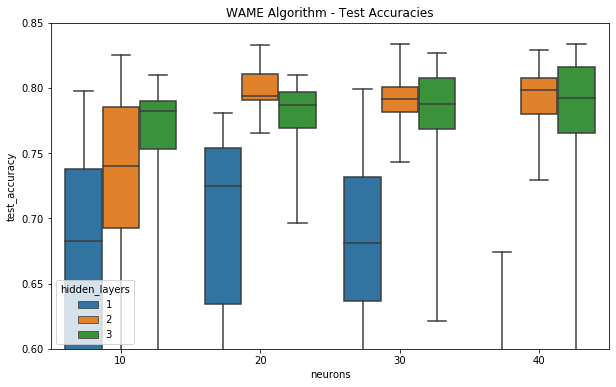

In [49]:
plt.figure(figsize=(10, 6))
axes = plt.axes()
axes.set_ylim([0.6, 0.85])
sns.boxplot(x='neurons',y='test_accuracy',data=df_wame, hue='hidden_layers', whis=[0,100]).set_title('WAME Algorithm - Test Accuracies');

TODO: Consider sub-plot to illustrate test accuracy vs train accuracy, or comparison of optimisers

### Scratch:

In [ ]:
retrieve_experiment(wame_mosca_results, conditions)

In [ ]:
test_losses_wame

In [ ]:
epochs = history.history['val_acc']
epochs.index(max(epochs))

In [ ]:
history.history.keys()

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')
plt.show()